# Intro

Today we're gonna speak about an ultimate validation framework that takes only several lines of code to implement but can solve most of doubts and questions during your AB career:

> Monte Carlo Simulation

I guess many of you are familiar with this method but do not use it as often as we should.

Let me try to convince you that a nice Monte Carlo framework deployed into your workflow is better than a new trendy habit of outsourcing our reasoning and validations by simply asking ChatGPT. 


**Disclaimer**

> This is not scientific research by any means, I won't introduce a complex theory or innovative method of solving the problems instead the article is a **cookbook** to guide you through the main use cases when the MC is an **essential tool for validating your ideas and other methodologies*


# Foundation

Before defining Monte-Carlo as a tool, let's take a step back and briefly discuss the statistics concept behind the AB testing.

While the Bayesian AB methods are gaining popularity nowadays, the frequentist approach remains the king of the hill. So, I assume most of you use a frequent-based interpretation and corresponding methodologies for estimating the experimentation results.


> Frequentist statistics is the traditional framework for making sense of data and uncertainty **through the long-run frequency**. When we apply this to A/B testing, we are engaging with a world where probability is tied to the **idea of repeatable**, long-term patterns rather than beliefs or subjective chances.

## Probability as Frequency

In the frequentist viewpoint, **probability** is defined as the limit of the expected **frequency of an event over many, many trials**. For example, when we say there's a 50% chance of flipping heads on a coin, we mean that if we could flip the coin an infinite number of times, about half of those flips would come up heads.


## Inference Through Hypothesis Testing

Quick recap:

When you run an A/B test, you're essentially conducting a hypothesis test. You have a null hypothesis (H0) that there is no difference between A and B, and an alternative hypothesis (H1) that there is a difference.


Frequentist inference uses data from your samples to assess the strength of evidence against the null hypothesis.

This is where the p-value comes into play.

It's calculated from your data and represents:

> **The probability** of observing results as extreme as you did, or more so, assuming the null hypothesis is true.

If this probability is low, it suggests that such an extreme result is unlikely to have occurred by random chance alone, leading us to reject the null hypothesis.

## Confidence Intervals and Estimation:

A 95% CI means that if **we could repeat our experiment over and over again**, 95% of the time the interval would capture the true parameter we're estimating. It's a range derived from the sample data that conveys where the true value lies with a certain level of confidence.


# Monte Carlo Simulations and Frequentist Statistics:

Can you see the main driver of the correct uncertainty estimations?

- **frequency of an event over many, many trials**
- **through the long-run frequency**
- **idea of repeatable**

Well, if the modern CPUs are so good in computations compared to the age of discovering a T-test ... . Can we just repeatedly simulate things over and over to make a bulletproof validation? Yes! This is exactly, what a Monte-Carlo is in a nutshell!


Monte Carlo simulations can be used within the frequentist paradigm to understand the behavior of statistics under **repeated sampling**.


-----

Monte Carlo allows us to perform "virtual experiments" by simulating the process of data collection and analysis many times over, which helps in understanding the distribution of our test statistic under the null hypothesis or in evaluating the properties of our confidence intervals.

-----


Monte Carlo is rooted deeply in the frequentist logic. It gives us a robust method for validating almost anything we may need during the AB research work:

- Statistical criteria applicability and correctness
- Performing power analysis for different treatment effects
- Testing new techniques and tricks
- ...

Long story short, in practice, we can resolve almost any doubts about our methodologies and math just by performing the right Monte Carlo simulation. As well as educating ourselves by studying the MC results.


# That's it?

I understand that most of you are already experienced AB scientists and Monte-Carlo is not a rocket science to present.

However, my goal is to remind you how powerful the technique actually is. To do that, let's go through some interesting examples, when MC can save you from making mistakes in your AB analysis and debunk some rusty AB myths along the road.




# Imports

In [11]:
import numpy as np
from tqdm import tqdm
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import shapiro
from tools.vizualization import Visualiser
from tools.config import LOG_NORMAL_EXAMPLE, SAMPLE_SIZE, MONTE_CARLO_ITERS, EXPECTED_VALUE, ALPHA
from tools.statistics import Statistics
from tools.distributions import DistributionGenerator

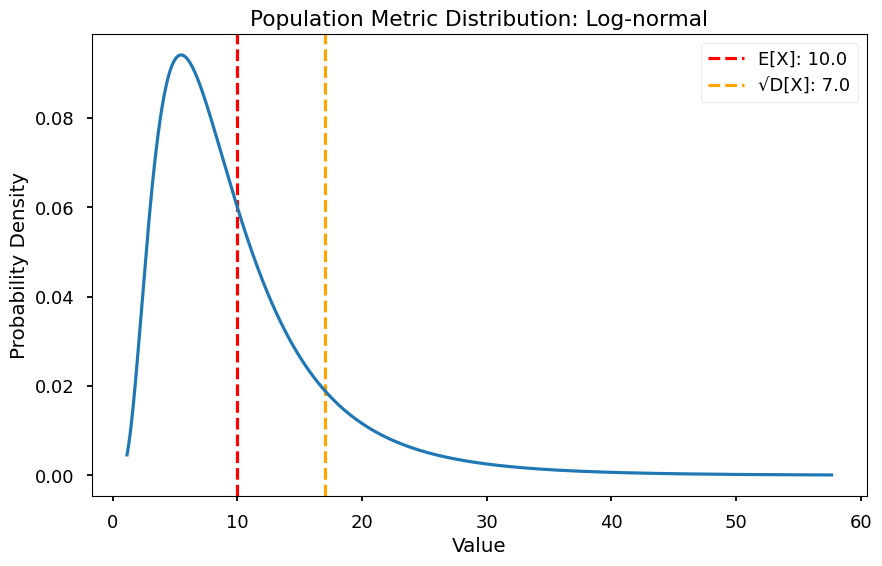

In [4]:
population_distribution_visualisation = Visualiser.visualise_distribution_pdf(
        LOG_NORMAL_EXAMPLE, title='Population Metric Distribution: Log-normal'
)

# How sampling looks like

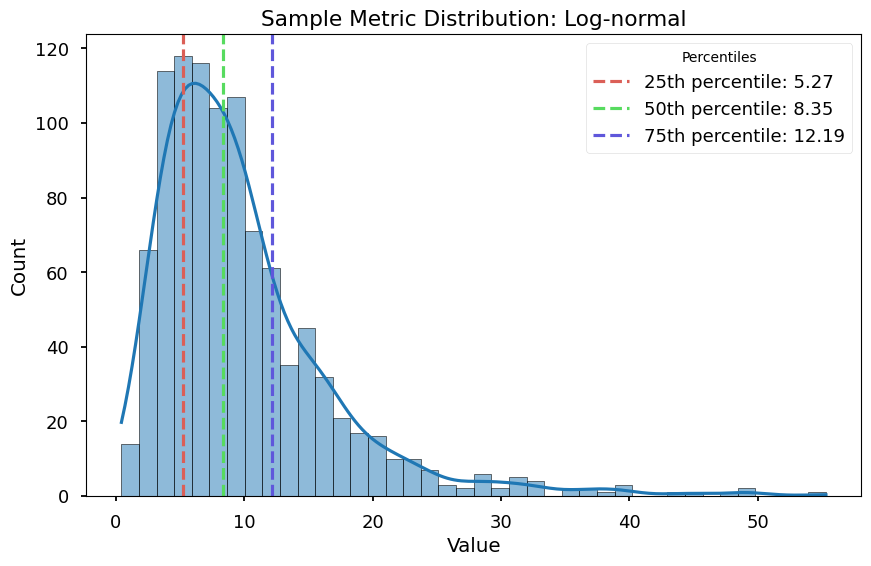

In [8]:
sample_distribution_visualisation = Visualiser.visualize_sample_distribution(
        DistributionGenerator.sample_from_distribution(LOG_NORMAL_EXAMPLE, SAMPLE_SIZE),
        title='Sample Metric Distribution: Log-normal'
)

# Basic Monte Carlo Simulation

tbd

100%|██████████| 10000/10000 [00:00<00:00, 11360.25it/s]


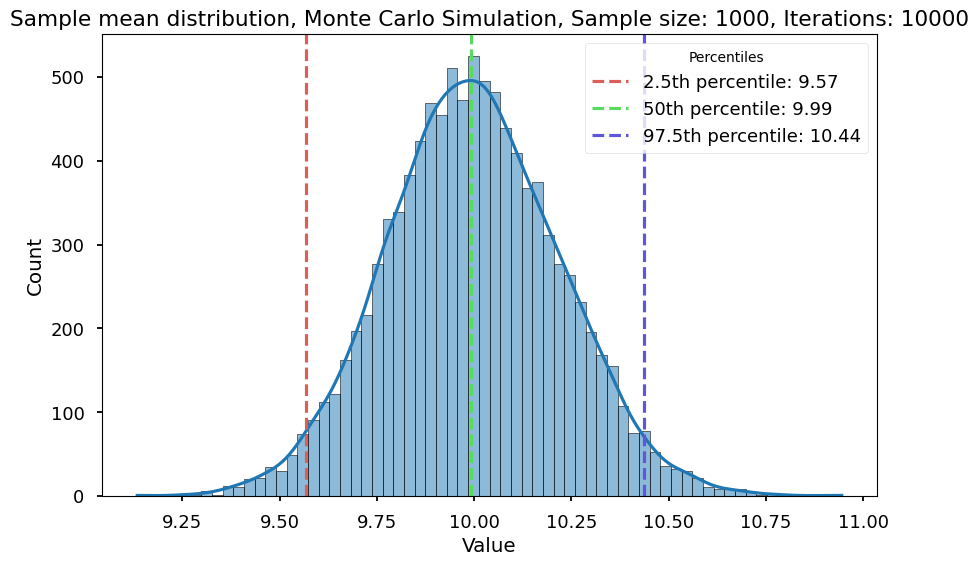

False positive rate: 0.0546 [0.0503, 0.0592]


In [10]:
sample_mean_distribution = list()
fpr_count = 0
for _ in tqdm(range(MONTE_CARLO_ITERS)):
    # Generate a sample from the population distribution
    sample = DistributionGenerator.sample_from_distribution(LOG_NORMAL_EXAMPLE, SAMPLE_SIZE)
    sample_mean = np.mean(sample)
    sample_mean_distribution.append(sample_mean)

    # Try to estimate the E[X] using the sample mean
    ci = Statistics.estimate_expected_value_ci(sample, alpha=ALPHA, method='norm')
    if ci.lower > EXPECTED_VALUE or ci.upper < EXPECTED_VALUE:
        fpr_count += 1

# Visualize the sample mean distribution
monte_carlo_distribution = Visualiser.visualize_sample_distribution(
    sample_mean_distribution,
    percentiles=(2.5, 50, 97.5),
    title=f'Sample mean distribution, Monte Carlo Simulation, Sample size: {SAMPLE_SIZE}, Iterations: {MONTE_CARLO_ITERS}'
)

# Calculate the false positive rate
fpr = fpr_count / MONTE_CARLO_ITERS
fpr_ci_low, fpr_ci_up = proportion_confint(fpr_count, MONTE_CARLO_ITERS, alpha=0.05, method='wilson')
print(f'False positive rate: {fpr:.4f} [{fpr_ci_low:.4f}, {fpr_ci_up:.4f}]')

# T-test applicability example

100%|██████████| 10000/10000 [00:01<00:00, 7544.51it/s]


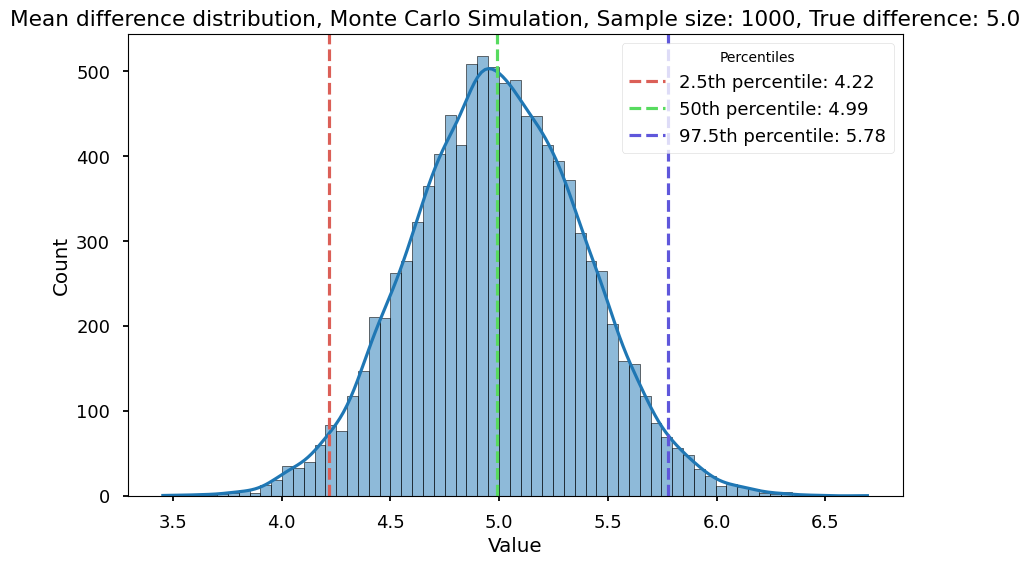

False positive rate: 0.0494 [0.0453, 0.0538]
P-Value: 0.9752798676490784
Shapiro-Wilk test passed (fail to reject H0)


/Users/nikita.fomichev/Library/Caches/pypoetry/virtualenvs/mc-guide-kiwitalk-2023-kyuxapBP-py3.11/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [13]:
"""

Validating statistical test applicability best practices:

1. Measuring FPR and Power is better than validating assumptions separately. 
Assumption validation can be trickier and might have loose thresholds.

2. Simulate AA tests with known effect size and check if the test can estimate the true difference. 
It's better than running AA tests against 0 difference since it's more realistic and can reveal more mistakes.

3. Try different distributions, sample sizes, and effect sizes. Model your real data, 
but also try to break it with corner cases.

5. Rule of thumb: FPR > alpha means underestimation of statistic's variance, issues with core assumptions.
FPR < alpha means underpowered test, the CI is too wide, the test is too conservative.

"""

# Configuration
UPLIFT_FACTOR = 1.5  # 1.5x uplift
TRUE_DIFF = (EXPECTED_VALUE * UPLIFT_FACTOR) - EXPECTED_VALUE

# Monte Carlo simulation
fpr_count = 0
mean_difference_distribution = list()
for _ in tqdm(range(MONTE_CARLO_ITERS)):

    # Generate a sample from the population distribution
    control = DistributionGenerator.sample_from_distribution(LOG_NORMAL_EXAMPLE, SAMPLE_SIZE)
    treatment = DistributionGenerator.sample_from_distribution(LOG_NORMAL_EXAMPLE, SAMPLE_SIZE)
    treatment *= UPLIFT_FACTOR

    diff, diff_ci = Statistics.mean_difference_ci(control, treatment, alpha=ALPHA)
    mean_difference_distribution.append(diff)

    if diff_ci.lower > TRUE_DIFF or diff_ci.upper < TRUE_DIFF:
        fpr_count += 1


# Visualize the sample mean distribution
Visualiser.save_plot(
    Visualiser.visualize_sample_distribution(
        mean_difference_distribution,
        percentiles=(2.5, 50, 97.5),
        title=f'Mean difference distribution, Monte Carlo Simulation, Sample size: {SAMPLE_SIZE}, True difference: {TRUE_DIFF}')
    , "mean_difference_distribution"
)

# Calculate the false positive rate
fpr = fpr_count / MONTE_CARLO_ITERS
fpr_ci_low, fpr_ci_up = proportion_confint(fpr_count, MONTE_CARLO_ITERS, alpha=0.05, method='wilson')
print(f'False positive rate: {fpr:.4f} [{fpr_ci_low:.4f}, {fpr_ci_up:.4f}]')


# Shapiro-Wilk test is a bad choice for MC checks because it is very sensitive to sample size
stat, p_value = shapiro(mean_difference_distribution)

# Output the results
print('P-Value:', p_value)
if p_value > ALPHA:
    print('Shapiro-Wilk test passed (fail to reject H0)')
else:
    print('ALERT! Shapiro-Wilk test failed (reject H0), t-test could not be applied')

# Catching the wrong relative t-test

100%|██████████| 10000/10000 [00:01<00:00, 7306.99it/s]


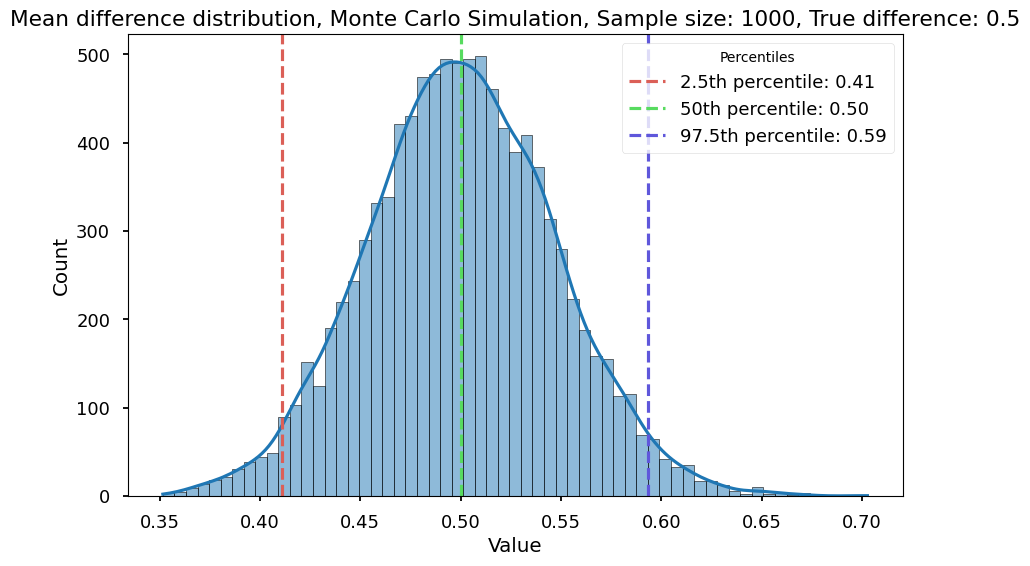

False positive rate: 0.0980 [0.0923, 0.1040]


In [15]:
"""
This is an example on how we can catch a wrong criteria. Imagine we want to estimate the relative difference between
the control and treatment groups. 

- Can we use the mean difference confidence interval and divide it by the control mean to get the relative difference?
- No! This approach is wrong. 

It underestimates the variance of the relative difference caused by an extra noise in denominator. MC helps to catch it.

"""
UPLIFT_FACTOR = 1.5
TRUE_DIFF = (EXPECTED_VALUE * UPLIFT_FACTOR) - EXPECTED_VALUE
RELATIVE_TRUE_DIFF = TRUE_DIFF / EXPECTED_VALUE


# Monte Carlo simulation

mean_difference_distribution = list()
fpr_count = 0
for _ in tqdm(range(MONTE_CARLO_ITERS)):

    # Generate a sample from the population distribution
    control = DistributionGenerator.sample_from_distribution(LOG_NORMAL_EXAMPLE, SAMPLE_SIZE)
    treatment = DistributionGenerator.sample_from_distribution(LOG_NORMAL_EXAMPLE, SAMPLE_SIZE)
    treatment *= UPLIFT_FACTOR
    diff, diff_ci = Statistics.mean_difference_ci(control, treatment, alpha=ALPHA)

    relative_diff = diff / np.mean(control)
    mean_difference_distribution.append(relative_diff)

    # THIS IS WRONG, IT'S NOT A VALID RELATIVE CI ESTIMATION, MONTE CARLO SHOULD SHOW IT
    if diff_ci.lower / np.mean(control) > RELATIVE_TRUE_DIFF or diff_ci.upper / np.mean(control) < RELATIVE_TRUE_DIFF:
        fpr_count += 1

# Visualize the sample mean distribution
Visualiser.visualize_sample_distribution(
    mean_difference_distribution,
    percentiles=(2.5, 50, 97.5),
    title=f'Mean difference distribution, Monte Carlo Simulation, Sample size: {SAMPLE_SIZE}, True difference: {RELATIVE_TRUE_DIFF}'
)

# Calculate the false positive rate
fpr = fpr_count / MONTE_CARLO_ITERS
fpr_ci_low, fpr_ci_up = proportion_confint(fpr_count, MONTE_CARLO_ITERS, alpha=0.05, method='wilson')
print(f'False positive rate: {fpr:.4f} [{fpr_ci_low:.4f}, {fpr_ci_up:.4f}]')

# Play with outlier filtering

100%|██████████| 10000/10000 [00:01<00:00, 5097.05it/s]


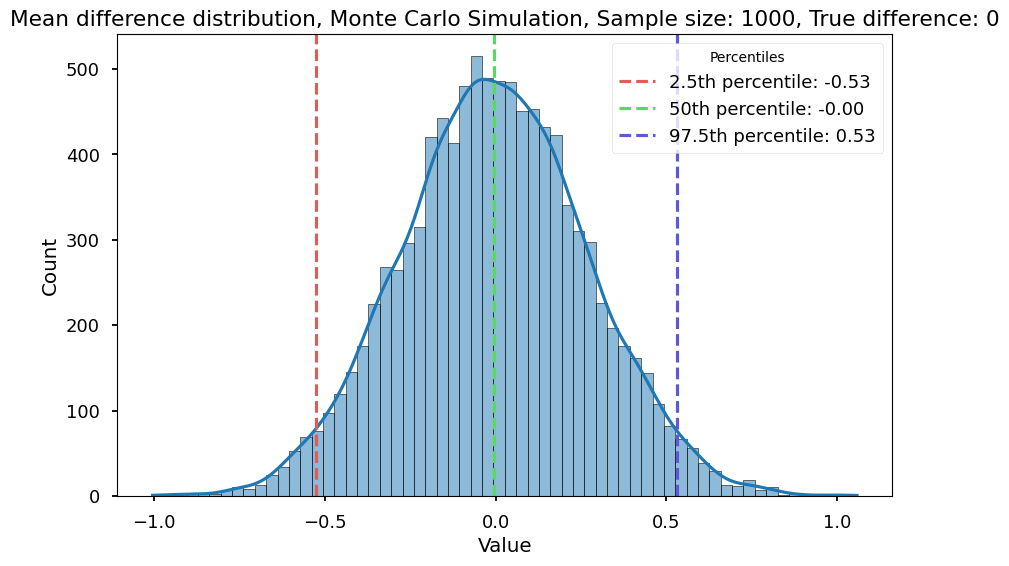

False positive rate: 0.0503 [0.0462, 0.0548]


In [16]:
"""
This is an example on how we can catch a wrong criteria. Imagine we want to estimate the relative difference between
the control and treatment groups. 

- Can we use the mean difference confidence interval and divide it by the control mean to get the relative difference?
- No! This approach is wrong. 

It underestimates the variance of the relative difference caused by an extra noise in denominator. MC helps to catch it.

"""
UPLIFT_FACTOR = 1  # No uplift
TRUE_DIFF = (EXPECTED_VALUE * UPLIFT_FACTOR) - EXPECTED_VALUE

# Monte Carlo simulation
mean_difference_distribution = list()
fpr_count = 0
for _ in tqdm(range(MONTE_CARLO_ITERS)):
    # Generate a sample from the population distribution
    control = DistributionGenerator.sample_from_distribution(LOG_NORMAL_EXAMPLE, SAMPLE_SIZE)
    treatment = DistributionGenerator.sample_from_distribution(LOG_NORMAL_EXAMPLE, SAMPLE_SIZE)
    common_pre_experiment_percentile = np.percentile(np.concatenate([control, treatment]), 99)

    # Incorrect filtering

    # control = control[control < np.percentile(control, 99)]
    # treatment = treatment[treatment < np.percentile(treatment, 99)]

    # Valid filtering
    control = control[control < common_pre_experiment_percentile]
    treatment = treatment[treatment < common_pre_experiment_percentile]
    treatment *= UPLIFT_FACTOR

    diff, diff_ci = Statistics.mean_difference_ci(control, treatment, alpha=ALPHA)
    mean_difference_distribution.append(diff)

    if diff_ci.lower > TRUE_DIFF or diff_ci.upper < TRUE_DIFF:
        fpr_count += 1

# Visualize the sample mean distribution
Visualiser.visualize_sample_distribution(
    mean_difference_distribution,
    percentiles=(2.5, 50, 97.5),
    title=f'Mean difference distribution, Monte Carlo Simulation, Sample size: {SAMPLE_SIZE}, True difference: {TRUE_DIFF}'
)

# Calculate the false positive rate
fpr = fpr_count / MONTE_CARLO_ITERS
fpr_ci_low, fpr_ci_up = proportion_confint(fpr_count, MONTE_CARLO_ITERS, alpha=0.05, method='wilson')
print(f'False positive rate: {fpr:.4f} [{fpr_ci_low:.4f}, {fpr_ci_up:.4f}]')